In [1]:
import pyodbc
from meyerDB import cable_connection
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML, display
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeavePOut
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as mse
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor
import sklearn.preprocessing as pp
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, RBF2, WhiteKernel, ConstantKernel, RationalQuadratic
from scipy.stats import norm
#from constrainedGP import ConstrainedGP

# init db connection
conn = pyodbc.connect(cable_connection)
cursor = conn.cursor()
print('Database connection ok')

def display_table(data):
    html = "<table>"
    for row in data:
        html += "<tr>"
        for field in row:
            try:
                value = str(round(100*field, 1)).replace('.', ',') + '%'
            except:
                value = field
            html += "<td><h4>%s</h4><td>"%(value)
        html += "</tr>"
    html += "</table>"
    display(HTML(html))



Database connection ok


C:\Users\sainmi53\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 10. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


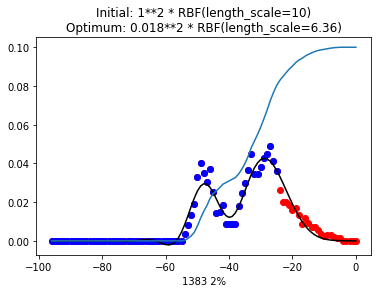

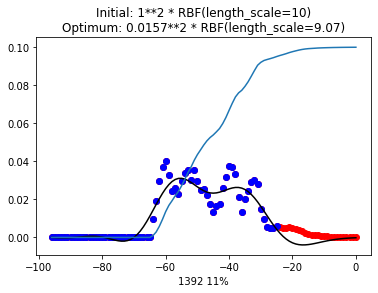

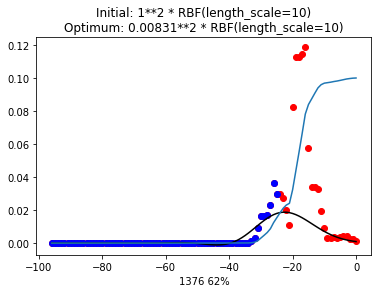

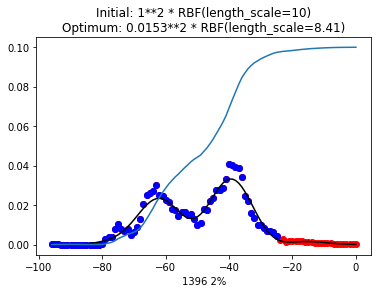

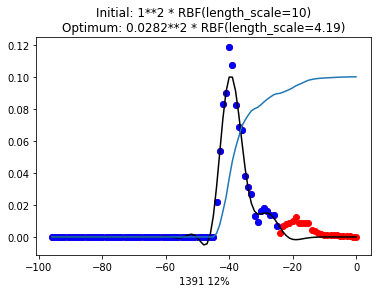

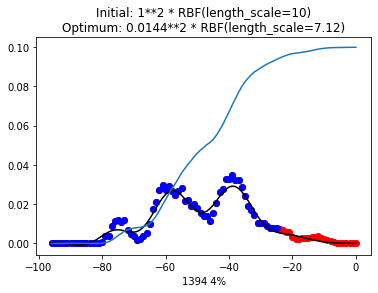

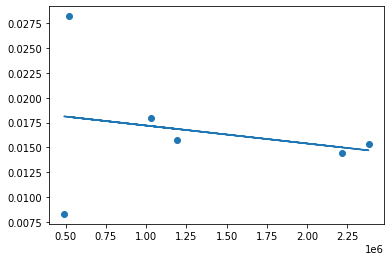

In [15]:
# Dynamic whole ship cable quantities
# Predictors:
# Current quantity intervals, past 10 week time series
# Algorithms:
# Gaussian process regression

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n
        
# Get the data
cursor.execute("SELECT r.project_id, gross_tonnage, sum(amount) FROM routed as r"
    " LEFT JOIN projects as p ON p.project_id=r.project_id"
    " WHERE p.prototype=1"
    " GROUP BY r.project_id, gross_tonnage")
data = np.array(cursor.fetchall())
ships = data[:, 0]
gt = data[:, 1]
cables = data[:, -1]
# init lpo split
p = 2 #ships
lpo = LeavePOut(p)

# update temporary cable counts
cursor.execute("UPDATE progress SET cables=0")
cursor.execute(
    "UPDATE progress SET progress.cables=t1.cables FROM"
    " (SELECT project_id, pw, sum(amount) as cables FROM ship_readiness GROUP BY project_id, pw) t1"
    " WHERE t1.project_id=progress.project_id AND t1.pw=progress.wk"
)
cursor.commit()
x = []
y2 = []
for i, ship in enumerate(ships):
    start, end = -100, 0
    cut = -25
    cursor.execute(
        "SELECT wk, cables FROM progress WHERE"
        " wk >= {} AND wk <= {} AND project_id={} ORDER BY wk"
        .format(start, end, ship)
    )
    data = np.array(cursor.fetchall())
    n = 5
    X = data[n-1:, 0].reshape(-1, 1)
    y = (data[:, -1])
    y = y/y.sum()
    y = moving_average(y, n=n)


# run
    plt.figure()
    cut_args = np.argwhere(X[:, 0]<=cut)[:, 0]
    kernel = 1.0 * RBF(length_scale=10.0, length_scale_bounds=(1, 10)) #\
    #    + WhiteKernel(noise_level=0.01, noise_level_bounds=(1e-10, 1))
    gp = GaussianProcessRegressor(kernel=kernel,
                                alpha=0.0001).fit(X[cut_args], y[cut_args])
    # clear point fit
    trained_kernel = gp.kernel_
    #gp = GaussianProcessRegressor(kernel=trained_kernel)

    y_mean, y_cov = gp.predict(X, return_cov=True)
    #y_mean = gpc.get_mean_f()
    #y_cov = gpc.get_cov()
    plt.plot(X, y_mean, 'k')
    #plt.fill_between(X[:, 0], y_mean - np.sqrt(np.diag(y_cov)),
                    #y_mean + np.sqrt(np.diag(y_cov)),
                    #alpha=0.5, color='k')
    plt.scatter(X[:, 0], y, c='r')
    plt.scatter(X[cut_args], y[cut_args], c='b')
    
    plt.title("Initial: %s\nOptimum: %s"
            % (kernel, trained_kernel))
    cut_args = np.argwhere(X[:, 0]>=cut)
    pred = y_mean.sum()
    real = y.sum()
    err = abs(pred-real)/real
    plt.xlabel(str(ship) + ' ' + str(round(100*err)) + '%')
    k1 = float(str(trained_kernel.k1).split("**")[0])
    x.append(cables[i])
    y2.append(k1)
    plt.plot(X[:, 0], y.cumsum()/10)
plt.figure()
fit = np.polyfit(x, y2, 1)
plt.plot(x, np.poly1d(fit)(x))
plt.scatter(x, y2)


C:\Users\sainmi53\AppData\Local\Temp/ipykernel_17824/3558974565.py:66: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_fit = np.array(y_fit)
C:\Users\sainmi53\AppData\Local\Temp/ipykernel_17824/3558974565.py:67: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  X_fit = np.array(X_fit)


(2.3000000000000003, 0.05600000000000001, 0.01)


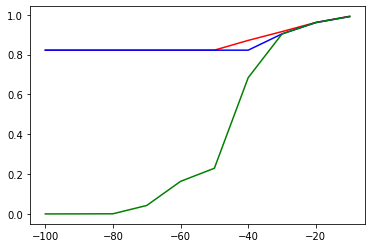

C:\Users\sainmi53\AppData\Local\Temp/ipykernel_17824/3558974565.py:66: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_fit = np.array(y_fit)
C:\Users\sainmi53\AppData\Local\Temp/ipykernel_17824/3558974565.py:67: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  X_fit = np.array(X_fit)


(2.3000000000000003, 0.05600000000000001, 0.01)


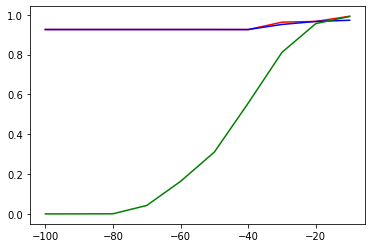

C:\Users\sainmi53\AppData\Local\Temp/ipykernel_17824/3558974565.py:66: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_fit = np.array(y_fit)
C:\Users\sainmi53\AppData\Local\Temp/ipykernel_17824/3558974565.py:67: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  X_fit = np.array(X_fit)


(2.3000000000000003, 0.045000000000000005, 0.01)


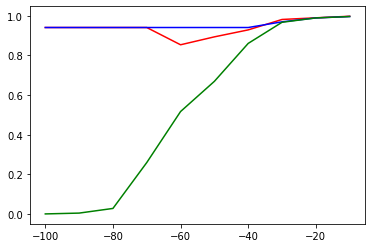

C:\Users\sainmi53\AppData\Local\Temp/ipykernel_17824/3558974565.py:66: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_fit = np.array(y_fit)
C:\Users\sainmi53\AppData\Local\Temp/ipykernel_17824/3558974565.py:67: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  X_fit = np.array(X_fit)


(2.3000000000000003, 0.067, 0.01)


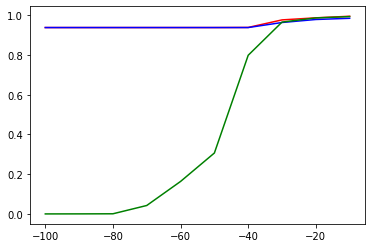

C:\Users\sainmi53\AppData\Local\Temp/ipykernel_17824/3558974565.py:66: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_fit = np.array(y_fit)
C:\Users\sainmi53\AppData\Local\Temp/ipykernel_17824/3558974565.py:67: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  X_fit = np.array(X_fit)


(3.4000000000000004, 0.001, 0.01)


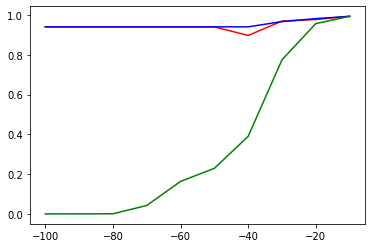

C:\Users\sainmi53\AppData\Local\Temp/ipykernel_17824/3558974565.py:66: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_fit = np.array(y_fit)
C:\Users\sainmi53\AppData\Local\Temp/ipykernel_17824/3558974565.py:67: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  X_fit = np.array(X_fit)


(3.4000000000000004, 0.023000000000000003, 0.01)


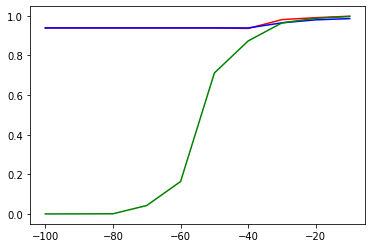

C:\Users\sainmi53\AppData\Local\Temp/ipykernel_17824/3558974565.py:66: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_fit = np.array(y_fit)
C:\Users\sainmi53\AppData\Local\Temp/ipykernel_17824/3558974565.py:67: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  X_fit = np.array(X_fit)


(2.3000000000000003, 0.045000000000000005, 0.01)


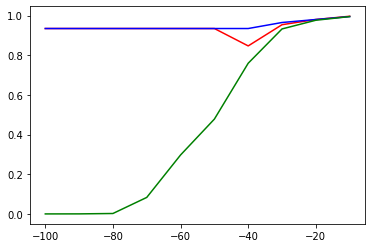

C:\Users\sainmi53\AppData\Local\Temp/ipykernel_17824/3558974565.py:66: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_fit = np.array(y_fit)
C:\Users\sainmi53\AppData\Local\Temp/ipykernel_17824/3558974565.py:67: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  X_fit = np.array(X_fit)


(2.3000000000000003, 0.07800000000000001, 0.01)


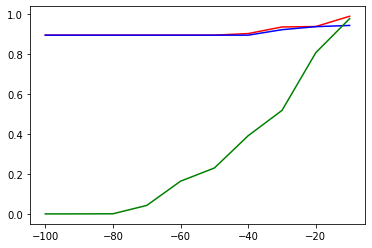

C:\Users\sainmi53\AppData\Local\Temp/ipykernel_17824/3558974565.py:66: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_fit = np.array(y_fit)
C:\Users\sainmi53\AppData\Local\Temp/ipykernel_17824/3558974565.py:67: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  X_fit = np.array(X_fit)


(2.3000000000000003, 0.067, 0.01)


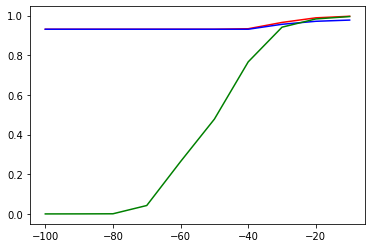

C:\Users\sainmi53\AppData\Local\Temp/ipykernel_17824/3558974565.py:66: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_fit = np.array(y_fit)
C:\Users\sainmi53\AppData\Local\Temp/ipykernel_17824/3558974565.py:67: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  X_fit = np.array(X_fit)


(2.3000000000000003, 0.067, 0.01)


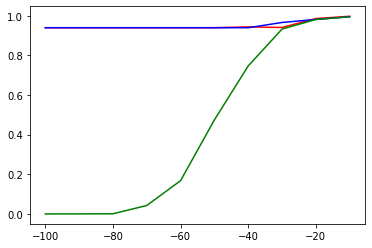

C:\Users\sainmi53\AppData\Local\Temp/ipykernel_17824/3558974565.py:66: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_fit = np.array(y_fit)
C:\Users\sainmi53\AppData\Local\Temp/ipykernel_17824/3558974565.py:67: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  X_fit = np.array(X_fit)


(2.3000000000000003, 0.07800000000000001, 0.01)


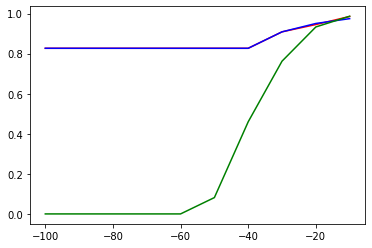

C:\Users\sainmi53\AppData\Local\Temp/ipykernel_17824/3558974565.py:66: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_fit = np.array(y_fit)
C:\Users\sainmi53\AppData\Local\Temp/ipykernel_17824/3558974565.py:67: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  X_fit = np.array(X_fit)


(2.3000000000000003, 0.05600000000000001, 0.01)


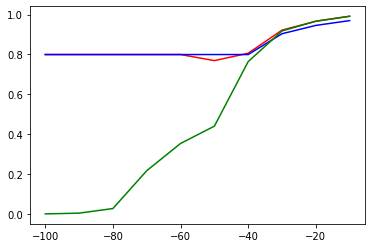

C:\Users\sainmi53\AppData\Local\Temp/ipykernel_17824/3558974565.py:66: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_fit = np.array(y_fit)
C:\Users\sainmi53\AppData\Local\Temp/ipykernel_17824/3558974565.py:67: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  X_fit = np.array(X_fit)


(2.3000000000000003, 0.07800000000000001, 0.01)


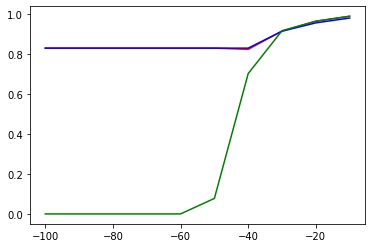

C:\Users\sainmi53\AppData\Local\Temp/ipykernel_17824/3558974565.py:66: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_fit = np.array(y_fit)
C:\Users\sainmi53\AppData\Local\Temp/ipykernel_17824/3558974565.py:67: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  X_fit = np.array(X_fit)


(2.3000000000000003, 0.1, 0.01)


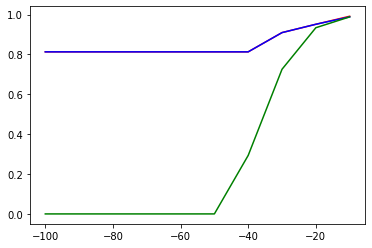

C:\Users\sainmi53\AppData\Local\Temp/ipykernel_17824/3558974565.py:66: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_fit = np.array(y_fit)
C:\Users\sainmi53\AppData\Local\Temp/ipykernel_17824/3558974565.py:67: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  X_fit = np.array(X_fit)


(3.4000000000000004, 0.023000000000000003, 0.01)


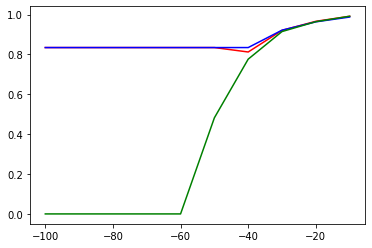

C:\Users\sainmi53\AppData\Local\Temp/ipykernel_17824/3558974565.py:66: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_fit = np.array(y_fit)
C:\Users\sainmi53\AppData\Local\Temp/ipykernel_17824/3558974565.py:67: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  X_fit = np.array(X_fit)


(2.3000000000000003, 0.067, 0.01)


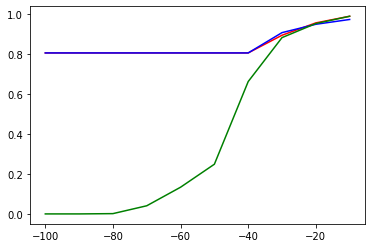

C:\Users\sainmi53\AppData\Local\Temp/ipykernel_17824/3558974565.py:66: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_fit = np.array(y_fit)
C:\Users\sainmi53\AppData\Local\Temp/ipykernel_17824/3558974565.py:67: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  X_fit = np.array(X_fit)


(3.4000000000000004, 0.001, 0.01)


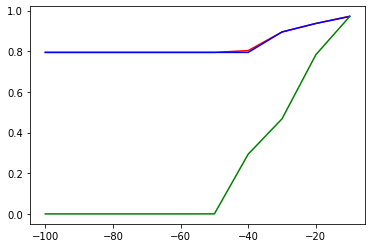

C:\Users\sainmi53\AppData\Local\Temp/ipykernel_17824/3558974565.py:66: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_fit = np.array(y_fit)
C:\Users\sainmi53\AppData\Local\Temp/ipykernel_17824/3558974565.py:67: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  X_fit = np.array(X_fit)


(2.3000000000000003, 0.07800000000000001, 0.01)


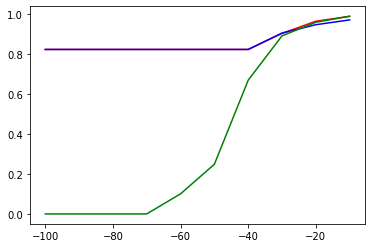

C:\Users\sainmi53\AppData\Local\Temp/ipykernel_17824/3558974565.py:66: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_fit = np.array(y_fit)
C:\Users\sainmi53\AppData\Local\Temp/ipykernel_17824/3558974565.py:67: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  X_fit = np.array(X_fit)


(2.3000000000000003, 0.07800000000000001, 0.01)


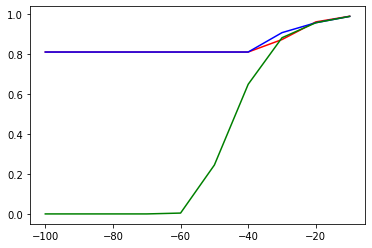

C:\Users\sainmi53\AppData\Local\Temp/ipykernel_17824/3558974565.py:66: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_fit = np.array(y_fit)
C:\Users\sainmi53\AppData\Local\Temp/ipykernel_17824/3558974565.py:67: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  X_fit = np.array(X_fit)


(2.3000000000000003, 0.045000000000000005, 0.01)


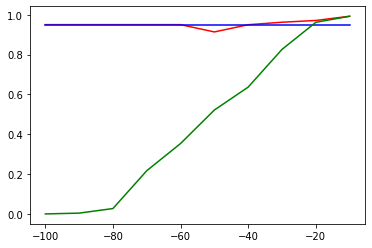

C:\Users\sainmi53\AppData\Local\Temp/ipykernel_17824/3558974565.py:66: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_fit = np.array(y_fit)
C:\Users\sainmi53\AppData\Local\Temp/ipykernel_17824/3558974565.py:67: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  X_fit = np.array(X_fit)


(2.3000000000000003, 0.067, 0.01)


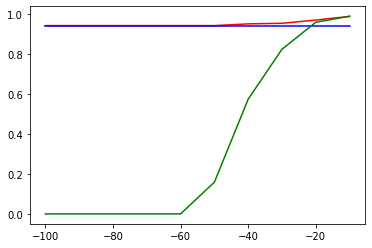

C:\Users\sainmi53\AppData\Local\Temp/ipykernel_17824/3558974565.py:66: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_fit = np.array(y_fit)
C:\Users\sainmi53\AppData\Local\Temp/ipykernel_17824/3558974565.py:67: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  X_fit = np.array(X_fit)


(2.3000000000000003, 0.1, 0.01)


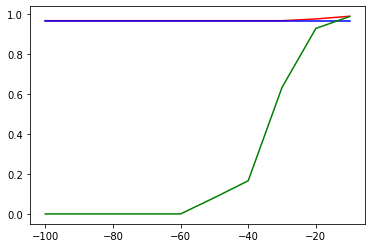

C:\Users\sainmi53\AppData\Local\Temp/ipykernel_17824/3558974565.py:66: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_fit = np.array(y_fit)
C:\Users\sainmi53\AppData\Local\Temp/ipykernel_17824/3558974565.py:67: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  X_fit = np.array(X_fit)


(3.4000000000000004, 0.023000000000000003, 0.01)


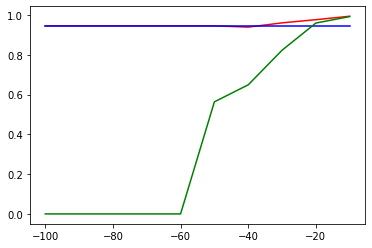

C:\Users\sainmi53\AppData\Local\Temp/ipykernel_17824/3558974565.py:66: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_fit = np.array(y_fit)
C:\Users\sainmi53\AppData\Local\Temp/ipykernel_17824/3558974565.py:67: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  X_fit = np.array(X_fit)


(2.3000000000000003, 0.05600000000000001, 0.01)


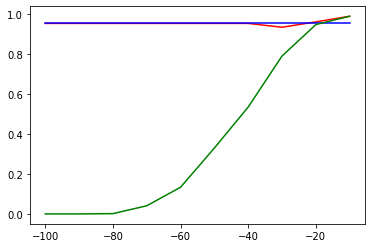

C:\Users\sainmi53\AppData\Local\Temp/ipykernel_17824/3558974565.py:66: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_fit = np.array(y_fit)
C:\Users\sainmi53\AppData\Local\Temp/ipykernel_17824/3558974565.py:67: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  X_fit = np.array(X_fit)


(3.4000000000000004, 0.001, 0.01)


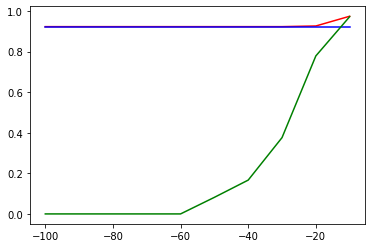

C:\Users\sainmi53\AppData\Local\Temp/ipykernel_17824/3558974565.py:66: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_fit = np.array(y_fit)
C:\Users\sainmi53\AppData\Local\Temp/ipykernel_17824/3558974565.py:67: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  X_fit = np.array(X_fit)


(2.3000000000000003, 0.07800000000000001, 0.01)


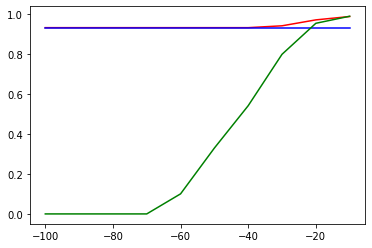

C:\Users\sainmi53\AppData\Local\Temp/ipykernel_17824/3558974565.py:66: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_fit = np.array(y_fit)
C:\Users\sainmi53\AppData\Local\Temp/ipykernel_17824/3558974565.py:67: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  X_fit = np.array(X_fit)


(2.3000000000000003, 0.07800000000000001, 0.01)


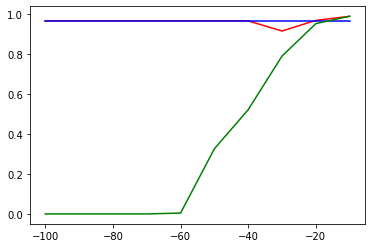

C:\Users\sainmi53\AppData\Local\Temp/ipykernel_17824/3558974565.py:66: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_fit = np.array(y_fit)
C:\Users\sainmi53\AppData\Local\Temp/ipykernel_17824/3558974565.py:67: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  X_fit = np.array(X_fit)


(2.3000000000000003, 0.05600000000000001, 0.01)


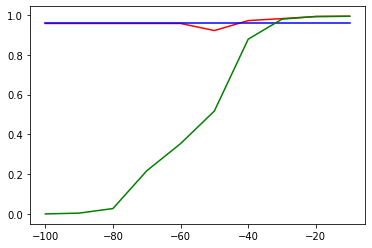

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [73]:
# Dynamic whole ship cable quantities
# Predictors:
# GT, past weeks time series
# Algorithms:
# Gaussian Process + Linear Regression

# Get the data
cursor.execute("SELECT r.project_id, gross_tonnage, prototype, sum(amount) FROM routed as r"
    " LEFT JOIN projects as p ON p.project_id=r.project_id"
    #" WHERE r.project_id<>1392"
    " GROUP BY r.project_id, gross_tonnage, prototype")
data = np.array(cursor.fetchall()).astype('float32')
ships = data[:, 0]
gt = data[:, 1]
pt = data[:, 2]
y = data[:, -1]

# init lpo split
p = 2 #ships
lpo = LeavePOut(p)

# update temporary cable counts
cursor.execute("UPDATE progress SET cables=0")
cursor.execute(
    "UPDATE progress SET progress.cables=t1.cables FROM"
    " (SELECT project_id, pw, sum(amount) as cables FROM ship_readiness GROUP BY project_id, pw) t1"
    " WHERE t1.project_id=progress.project_id AND t1.pw=progress.wk"
)
cursor.commit()

linearModel = linear_model.LinearRegression()



for train_i, test_i in lpo.split(y):

    # train regression model
    linearModel.fit(gt[train_i].reshape(-1, 1), y[train_i])

    # collect time series train data
    start = -100
    step = 10
    y_fit = []
    X_fit = []
    X_scalers = []
    y_train = []
    for wk in range(start, 1, step):
        for i in train_i:
            ship = ships[i]
            linear_pred = linearModel.predict(gt[[i]].reshape(1, -1))[0]
            cursor.execute(
                "SELECT wk, cables FROM progress WHERE"
                " wk <= {} AND project_id={} ORDER BY wk"
                .format(wk, ship)
            )
            data = np.array(cursor.fetchall())
            sequence = data[:, [-1]]
            xseq = data[:, [0]]
            if sequence.sum() >= (0.5*linear_pred):
                X_fit.append(xseq)
                X_scalers.append(linear_pred)
                y_fit.append(sequence/linear_pred)
                y_train.append(y[i])

    # grid search for optimal gaussian process
    y_fit = np.array(y_fit)
    X_fit = np.array(X_fit)
    X_scalers = np.array(X_scalers)
    y_train = np.array(y_train)
    rbf_length_scales = np.linspace(0.1, 10, 10)
    rbf_scales = np.linspace(0.001, 0.1, 10)
    noise_levels = [0.01]
    y_preds = []
    y_reals = []
    mses = []
    params = []
    for l in rbf_length_scales:
        for c in rbf_scales:
            for noise in noise_levels:
                kernel = ConstantKernel(constant_value=c, constant_value_bounds='fixed') * RBF(length_scale=l, length_scale_bounds='fixed') \
                    + WhiteKernel(noise_level=noise, noise_level_bounds='fixed')
                gp = GaussianProcessRegressor(kernel=kernel)
                for i in range(X_fit.shape[0]):
                    xseq = X_fit[i]
                    if xseq[-1]==0:
                        break
                    yseq = y_fit[i]
                    scaler = X_scalers[i]
                    gp.fit(xseq, yseq)
                    pred = gp.predict(np.arange(xseq[-1]+1, 1, 1).reshape(-1, 1))
                    y_pred = scaler*(yseq.sum() + pred.sum())
                    y_preds.append(y_pred)
                    y_reals.append(y_train[i])
                mses.append(mse(y_reals, y_preds))
                params.append((l, c, noise))
    mses = np.array(mses)
    best_i = np.argmin(mses)
    best_params = params[best_i]
    print(best_params)
    # evaluate model
    gaussian_accs = []
    linear_accs = []
    dummy_accs = []
    x = []
    for wk in range(start, 1, step):
        gaussian_preds = []
        y_reals = []
        linear_preds = []
        dummy_preds = []
        for i in test_i:
            ship = ships[i]
            linear_pred = linearModel.predict(gt[[i]].reshape(1, -1))[0]
            cursor.execute(
                "SELECT wk, cables FROM progress WHERE"
                " wk <= {} AND project_id={} ORDER BY wk"
                .format(wk, ship)
            )
            data = np.array(cursor.fetchall())
            sequence = data[:, [-1]]
            xseq = data[:, [0]]
            if sequence.sum() >= (0.5*linear_pred):
                (l, c, noise) = best_params
                kernel = ConstantKernel(constant_value=c, constant_value_bounds='fixed') * RBF(length_scale=l, length_scale_bounds='fixed') \
                    + WhiteKernel(noise_level=noise, noise_level_bounds='fixed')
                gp = GaussianProcessRegressor(kernel=kernel)
                gp.fit(xseq.reshape(-1, 1), sequence.reshape(-1, 1)/linear_pred)
                if xseq[-1]==0:
                    break
                pred = gp.predict(np.arange(xseq[-1]+1, 1, 1).reshape(-1, 1))
                y_pred = sequence.sum() + pred.sum()*linear_pred
                if abs(y_pred-linear_pred)/linear_pred > 0.2:
                    if sequence.sum() > linear_pred:
                        y_pred = sequence.sum()
                    else:
                        y_pred = linear_pred
            else:
                if sequence.sum() > linear_pred:
                    y_pred = sequence.sum()
                else:
                    y_pred = linear_pred
            
            gaussian_preds.append(y_pred)
            if sequence.sum() > linear_pred:
                linear_preds.append(sequence.sum())
            else:
                linear_preds.append(linear_pred)
            dummy_preds.append(sequence.sum())
            y_reals.append(y[i])
        if len(y_reals)<1: continue
        gaussian_mape = mape(y_reals, gaussian_preds)
        linear_mape = mape(y_reals, linear_preds)
        dummy_mape = mape(y_reals, dummy_preds)

        gaussian_accs.append(1-gaussian_mape)
        linear_accs.append(1-linear_mape)
        dummy_accs.append(1-dummy_mape)
        x.append(wk)
    
    plt.plot(x, gaussian_accs, 'r')
    plt.plot(x, linear_accs, 'b')
    plt.plot(x, dummy_accs, 'g')
    plt.show()
    plt.figure()
